In [8]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GroupKFold, StratifiedGroupKFold
import shap
import gpplot
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot
from rs3.seq import predict_seq
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
#optuna.logging.set_verbosity(optuna.logging.WARNING)


In [69]:
gilbert2014_rs3 = pd.read_csv('../data/gilbert_2014/gilbert2014_activity.csv')
gilbert2014_rs3 = gilbert2014_rs3.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
gilbert2014_rs3 = gilbert2014_rs3[['sgRNA Context Sequence', 'sgRNA Sequence', 
                 'Target Gene Symbol', 'Chen On-Target Efficacy Score',
                'sgRNA \'Cut\' Site TSS Offset', 'avg_gamma', 'avg_mean_centered_neg_gamma']]

In [70]:
gilbert2014_rs3['sgRNA Context Sequence']

0        ACAGAAAAACCGTCAGTAACACCGAGGACA
1        GAGGAAAAAGGAGGTGTCCGGGTAGGGCAA
2        GCAGAAAAATGGCAGCCGCCGCTCCGGACT
3        CTCGAAAAGCCGCAGGTAGGAGCAAGGATC
4        CTGGAAAAGGGGCGCGGTGAGCTAGGGCGG
                      ...              
10596    GGCGTTTGGGGAGCGCTGGGGTTGTGGTGG
10597    GCGGTTTGGTCCTTTCCGGGCGCGCGGGGG
10598    GACGTTTGGTGTTCCTGTGAACGTGGGGCG
10599    TGCGTTTGTTTCCGGCGTGGGTCCGGGCAA
10600    CACGTTTGTTTGGATTTAATCTTCAGGTTG
Name: sgRNA Context Sequence, Length: 10601, dtype: object

In [71]:
method = 'avg_mean_centered_neg_gamma'
gilbert2014_rs3['Residual'] = (gilbert2014_rs3[method])-gilbert2014_rs3['Chen On-Target Efficacy Score']

In [72]:

conditions = [
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 250) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 225),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 225) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 200),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 200) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 175),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 175) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 150),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 150) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 125),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 125) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 100),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 100) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 75),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 75) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 50),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 50) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 25),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 25) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 0),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= 0) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > -25),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= -25) & (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > -50),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] <= -50),
    (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset'] > 250)
]

values_tss = ['+225 to +250', '+200 to +225', '+175 to +200', '+150 to +175', '+125 to +150', '+100 to +125',
         '+75 to +100', '+50 to +75', '+25 to +50', '0 to +25', '-25 to 0', '-50 to -25', '<-50', '>+250' ]
gilbert2014_rs3['tss_bins'] = np.select(conditions, values_tss)


In [73]:
one_hot_encoding_tss = pd.get_dummies(gilbert2014_rs3.tss_bins, prefix='tss_bins')

In [74]:
gilbert2014_rs3 = pd.concat([gilbert2014_rs3, one_hot_encoding_tss], axis = 1)

In [75]:
X = gilbert2014_rs3[['sgRNA \'Cut\' Site TSS Offset', 'sgRNA Context Sequence','tss_bins_+100 to +125',
 'tss_bins_+125 to +150',
 'tss_bins_+150 to +175',
 'tss_bins_+175 to +200',
 'tss_bins_+200 to +225',
 'tss_bins_+225 to +250',
 'tss_bins_+25 to +50',
 'tss_bins_+50 to +75',
 'tss_bins_+75 to +100',
 'tss_bins_-25 to 0',
 'tss_bins_-50 to -25',
 'tss_bins_0 to +25',
 'tss_bins_<-50',
 'tss_bins_>+250']]
X = X.set_index('sgRNA Context Sequence')    
y = gilbert2014_rs3['Residual']
grps = gilbert2014_rs3['Target Gene Symbol']

In [48]:


def objective(trial, X, y, groups, cv=4 ):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01,0.02,0.03,0.04, 0.05]),
        "num_leaves": trial.suggest_int('num_leaves', 8, 256),
        "min_child_samples": trial.suggest_int('min_child_samples', 8, 256)

    }

    cv_scores = np.zeros(cv)
    
    #gkf_cv = GroupKFold(n_splits=3)
    gkf_cv = StratifiedGroupKFold(n_splits=cv, shuffle=True, random_state=1)
    df_group = pd.DataFrame()


    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X,[1]*grps, groups=groups)):
        X_train, X_test, y_train, y_test = X.iloc[ix_train], X.iloc[ix_test], y.iloc[ix_train], y.iloc[ix_test]

        model = LGBMRegressor(random_state=7, n_jobs=1, **param_grid)
        df_group = df_group.append({'fold': split, 'num_train_gene': len(set(grps[ix_train].tolist())),
                    'num_train_sgrna': len(grps[ix_train].tolist()), 
                    'num_test_gene': len(set(grps[ix_test].tolist())),
                   'num_test_sgRNA': len(grps[ix_test].tolist()),
                   'num_overlap_gene': len(list(set(grps[ix_train]) & set(grps[ix_test])))}, ignore_index=True)
        print(df_group)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            verbose=-1,
             early_stopping_rounds=50,)
        preds = model.score(X_train, y_train)
        
        cv_scores[split] = preds


    return 1-np.mean(cv_scores)

In [49]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")

def func(trial):
    return objective(trial, X, y, grps)

study.optimize(func, n_trials=50);

[I 2022-11-10 01:27:45,799] A new study created in memory with name: LGBM Regressor
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266698
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.253927
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:46,611] Trial 0 finished with value: 0.9970805163053166 and parameters: {'n_estimators': 467, 'learning_rate': 0.01, 'num_leaves': 194, 'min_child_samples': 186}. Best is trial 0 with value: 0.9970805163053166.


Early stopping, best iteration is:
[20]	valid_0's l2: 0.250419
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's l2: 0.259001


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266696
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.253913
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

[I 2022-11-10 01:27:47,348] Trial 1 finished with value: 0.9964393878547393 and parameters: {'n_estimators': 1152, 'learning_rate': 0.04, 'num_leaves': 98, 'min_child_samples': 223}. Best is trial 1 with value: 0.9964393878547393.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's l2: 0.2588


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.2667
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's l2: 0.253895


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:48,279] Trial 2 finished with value: 0.9961358707313436 and parameters: {'n_estimators': 622, 'learning_rate': 0.01, 'num_leaves': 120, 'min_child_samples': 79}. Best is trial 2 with value: 0.9961358707313436.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's l2: 0.250393
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
T

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266674
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.253915
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:49,119] Trial 3 finished with value: 0.9959813880955583 and parameters: {'n_estimators': 284, 'learning_rate': 0.03, 'num_leaves': 202, 'min_child_samples': 133}. Best is trial 3 with value: 0.9959813880955583.


Early stopping, best iteration is:
[13]	valid_0's l2: 0.250202
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.25908


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.266662
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 0.253831
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:49,889] Trial 4 finished with value: 0.9951578082465309 and parameters: {'n_estimators': 1438, 'learning_rate': 0.03, 'num_leaves': 160, 'min_child_samples': 112}. Best is trial 4 with value: 0.9951578082465309.


Early stopping, best iteration is:
[11]	valid_0's l2: 0.250226
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.259064


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266698
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's l2: 0.253965


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:50,738] Trial 5 finished with value: 0.9964060545266906 and parameters: {'n_estimators': 569, 'learning_rate': 0.01, 'num_leaves': 102, 'min_child_samples': 15}. Best is trial 4 with value: 0.9951578082465309.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's l2: 0.250389
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
T

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266683
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.253877
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:51,459] Trial 6 finished with value: 0.9955990850023633 and parameters: {'n_estimators': 223, 'learning_rate': 0.04, 'num_leaves': 34, 'min_child_samples': 118}. Best is trial 4 with value: 0.9951578082465309.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.25906


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266714
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.253909
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:52,186] Trial 7 finished with value: 0.9970376442057506 and parameters: {'n_estimators': 1184, 'learning_rate': 0.04, 'num_leaves': 94, 'min_child_samples': 188}. Best is trial 4 with value: 0.9951578082465309.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.25905


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.266663
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.253817


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:53,063] Trial 8 finished with value: 0.9951111044212558 and parameters: {'n_estimators': 561, 'learning_rate': 0.01, 'num_leaves': 173, 'min_child_samples': 116}. Best is trial 8 with value: 0.9951111044212558.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.25025
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266713
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.253898
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:53,824] Trial 9 finished with value: 0.9965940577599247 and parameters: {'n_estimators': 126, 'learning_rate': 0.04, 'num_leaves': 108, 'min_child_samples': 184}. Best is trial 8 with value: 0.9951111044212558.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's l2: 0.259043


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266698
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.25374
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:54,814] Trial 10 finished with value: 0.9944491558481349 and parameters: {'n_estimators': 852, 'learning_rate': 0.02, 'num_leaves': 247, 'min_child_samples': 26}. Best is trial 10 with value: 0.9944491558481349.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.259234


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266696
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's l2: 0.253869
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:55,879] Trial 11 finished with value: 0.995254006517057 and parameters: {'n_estimators': 856, 'learning_rate': 0.02, 'num_leaves': 256, 'min_child_samples': 10}. Best is trial 10 with value: 0.9944491558481349.


Early stopping, best iteration is:
[1]	valid_0's l2: 0.259257


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266717
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.254002
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:56,697] Trial 12 finished with value: 0.9959674769772031 and parameters: {'n_estimators': 853, 'learning_rate': 0.05, 'num_leaves': 253, 'min_child_samples': 64}. Best is trial 10 with value: 0.9944491558481349.


Early stopping, best iteration is:
[5]	valid_0's l2: 0.25024
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.259169


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266689
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.253994
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:57,523] Trial 13 finished with value: 0.9956853757418898 and parameters: {'n_estimators': 1062, 'learning_rate': 0.02, 'num_leaves': 211, 'min_child_samples': 56}. Best is trial 10 with value: 0.9944491558481349.


Early stopping, best iteration is:
[8]	valid_0's l2: 0.250271
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.259159


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266687
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 0.25389
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:58,299] Trial 14 finished with value: 0.9961679269330581 and parameters: {'n_estimators': 737, 'learning_rate': 0.02, 'num_leaves': 158, 'min_child_samples': 142}. Best is trial 10 with value: 0.9944491558481349.


Early stopping, best iteration is:
[17]	valid_0's l2: 0.25023
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's l2: 0.25909


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266687
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 0.253796


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:27:59,162] Trial 15 finished with value: 0.9947190124339578 and parameters: {'n_estimators': 437, 'learning_rate': 0.05, 'num_leaves': 229, 'min_child_samples': 40}. Best is trial 10 with value: 0.9944491558481349.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's l2: 0.25029
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tra

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266689
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 0.253724


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:00,024] Trial 16 finished with value: 0.9945769530840629 and parameters: {'n_estimators': 370, 'learning_rate': 0.05, 'num_leaves': 227, 'min_child_samples': 38}. Best is trial 10 with value: 0.9944491558481349.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's l2: 0.250251
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266709
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 0.253954
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:00,806] Trial 17 finished with value: 0.9962154671169349 and parameters: {'n_estimators': 987, 'learning_rate': 0.05, 'num_leaves': 226, 'min_child_samples': 86}. Best is trial 10 with value: 0.9944491558481349.


Early stopping, best iteration is:
[3]	valid_0's l2: 0.250351
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.259124


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266678
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.253989
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:01,691] Trial 18 finished with value: 0.9950202454293489 and parameters: {'n_estimators': 1325, 'learning_rate': 0.02, 'num_leaves': 56, 'min_child_samples': 37}. Best is trial 10 with value: 0.9944491558481349.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's l2: 0.250259
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.259148


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266696
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.253894
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:02,544] Trial 19 finished with value: 0.9970183795316322 and parameters: {'n_estimators': 737, 'learning_rate': 0.05, 'num_leaves': 238, 'min_child_samples': 255}. Best is trial 10 with value: 0.9944491558481349.


Early stopping, best iteration is:
[3]	valid_0's l2: 0.250448
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 0.258686


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.26669
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.253742


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's l2: 0.250339
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

[I 2022-11-10 01:28:03,565] Trial 20 finished with value: 0.994670237038711 and parameters: {'n_estimators': 353, 'learning_rate': 0.02, 'num_leaves': 187, 'min_child_samples': 34}. Best is trial 10 with value: 0.9944491558481349.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266687
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 0.253746
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:04,521] Trial 21 finished with value: 0.9941451833547703 and parameters: {'n_estimators': 334, 'learning_rate': 0.02, 'num_leaves': 184, 'min_child_samples': 32}. Best is trial 21 with value: 0.9941451833547703.


Early stopping, best iteration is:
[3]	valid_0's l2: 0.259225


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.266678
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.253879
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:05,481] Trial 22 finished with value: 0.994500037646469 and parameters: {'n_estimators': 129, 'learning_rate': 0.02, 'num_leaves': 142, 'min_child_samples': 8}. Best is trial 21 with value: 0.9941451833547703.


Early stopping, best iteration is:
[1]	valid_0's l2: 0.25925


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266679
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.253888


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.25042
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tra

[I 2022-11-10 01:28:06,453] Trial 23 finished with value: 0.9955366529346737 and parameters: {'n_estimators': 118, 'learning_rate': 0.02, 'num_leaves': 138, 'min_child_samples': 14}. Best is trial 21 with value: 0.9941451833547703.


Early stopping, best iteration is:
[1]	valid_0's l2: 0.259252


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266704
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 0.253947
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:07,319] Trial 24 finished with value: 0.9964220043425334 and parameters: {'n_estimators': 216, 'learning_rate': 0.02, 'num_leaves': 138, 'min_child_samples': 84}. Best is trial 21 with value: 0.9941451833547703.


Early stopping, best iteration is:
[10]	valid_0's l2: 0.250356
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.259138


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266682
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.25397


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:08,174] Trial 25 finished with value: 0.9961117488594501 and parameters: {'n_estimators': 956, 'learning_rate': 0.02, 'num_leaves': 74, 'min_child_samples': 59}. Best is trial 21 with value: 0.9941451833547703.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.250277
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266699
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.253749
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:09,313] Trial 26 finished with value: 0.9940836575947264 and parameters: {'n_estimators': 683, 'learning_rate': 0.02, 'num_leaves': 173, 'min_child_samples': 26}. Best is trial 26 with value: 0.9940836575947264.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.259234


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266689
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.253754
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:10,302] Trial 27 finished with value: 0.9949328923171687 and parameters: {'n_estimators': 672, 'learning_rate': 0.02, 'num_leaves': 173, 'min_child_samples': 30}. Best is trial 26 with value: 0.9940836575947264.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.259241


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.2667
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's l2: 0.253947


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.25031
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

[I 2022-11-10 01:28:11,276] Trial 28 finished with value: 0.9959589797097169 and parameters: {'n_estimators': 520, 'learning_rate': 0.02, 'num_leaves': 179, 'min_child_samples': 67}. Best is trial 26 with value: 0.9940836575947264.


Early stopping, best iteration is:
[6]	valid_0's l2: 0.259161


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266675
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.253975


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:12,188] Trial 29 finished with value: 0.9948707740387227 and parameters: {'n_estimators': 791, 'learning_rate': 0.03, 'num_leaves': 207, 'min_child_samples': 51}. Best is trial 26 with value: 0.9940836575947264.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.250232
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.2667
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's l2: 0.253888
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955   

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:13,016] Trial 30 finished with value: 0.9966831206345461 and parameters: {'n_estimators': 445, 'learning_rate': 0.02, 'num_leaves': 195, 'min_child_samples': 165}. Best is trial 26 with value: 0.9940836575947264.


Early stopping, best iteration is:
[13]	valid_0's l2: 0.250376
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's l2: 0.259112


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266688
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's l2: 0.253855


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:13,961] Trial 31 finished with value: 0.9952118850702165 and parameters: {'n_estimators': 238, 'learning_rate': 0.02, 'num_leaves': 152, 'min_child_samples': 8}. Best is trial 26 with value: 0.9940836575947264.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.250423
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266698
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 0.253714


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 0.250284
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
T

[I 2022-11-10 01:28:14,919] Trial 32 finished with value: 0.9936974355690902 and parameters: {'n_estimators': 308, 'learning_rate': 0.02, 'num_leaves': 149, 'min_child_samples': 27}. Best is trial 32 with value: 0.9936974355690902.


Early stopping, best iteration is:
[3]	valid_0's l2: 0.259233


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266691
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 0.253702
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:15,925] Trial 33 finished with value: 0.993867657265853 and parameters: {'n_estimators': 366, 'learning_rate': 0.02, 'num_leaves': 124, 'min_child_samples': 27}. Best is trial 32 with value: 0.9936974355690902.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.25923


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's l2: 0.266678
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 0.253787
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:16,816] Trial 34 finished with value: 0.995023387546138 and parameters: {'n_estimators': 354, 'learning_rate': 0.02, 'num_leaves': 121, 'min_child_samples': 100}. Best is trial 32 with value: 0.9936974355690902.


Early stopping, best iteration is:
[20]	valid_0's l2: 0.250233
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.259097


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266664
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.253929


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:17,779] Trial 35 finished with value: 0.9951795791277028 and parameters: {'n_estimators': 479, 'learning_rate': 0.03, 'num_leaves': 123, 'min_child_samples': 48}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.250309
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.2667
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 0.253935


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's l2: 0.250354
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
T

[I 2022-11-10 01:28:18,778] Trial 36 finished with value: 0.9961697210206322 and parameters: {'n_estimators': 641, 'learning_rate': 0.01, 'num_leaves': 157, 'min_child_samples': 77}. Best is trial 32 with value: 0.9936974355690902.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266704
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's l2: 0.253813


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:19,698] Trial 37 finished with value: 0.9942406158912716 and parameters: {'n_estimators': 291, 'learning_rate': 0.02, 'num_leaves': 92, 'min_child_samples': 26}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's l2: 0.250323
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266654
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 0.253815
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

[I 2022-11-10 01:28:20,373] Trial 38 finished with value: 0.9963296277334808 and parameters: {'n_estimators': 418, 'learning_rate': 0.04, 'num_leaves': 17, 'min_child_samples': 97}. Best is trial 32 with value: 0.9936974355690902.


Early stopping, best iteration is:
[11]	valid_0's l2: 0.258928


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266695
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's l2: 0.253866
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:21,285] Trial 39 finished with value: 0.9961229537178458 and parameters: {'n_estimators': 572, 'learning_rate': 0.01, 'num_leaves': 168, 'min_child_samples': 71}. Best is trial 32 with value: 0.9936974355690902.


Early stopping, best iteration is:
[11]	valid_0's l2: 0.259181


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266697
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.25377
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955   

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:22,306] Trial 40 finished with value: 0.9948966225029043 and parameters: {'n_estimators': 261, 'learning_rate': 0.03, 'num_leaves': 185, 'min_child_samples': 23}. Best is trial 32 with value: 0.9936974355690902.


Early stopping, best iteration is:
[1]	valid_0's l2: 0.259253


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266702
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's l2: 0.253858


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:23,256] Trial 41 finished with value: 0.9947631981697075 and parameters: {'n_estimators': 297, 'learning_rate': 0.02, 'num_leaves': 86, 'min_child_samples': 23}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.250419
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266684
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.254022


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:24,178] Trial 42 finished with value: 0.9961602032116855 and parameters: {'n_estimators': 307, 'learning_rate': 0.02, 'num_leaves': 72, 'min_child_samples': 47}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 0.250336
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
T

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266692
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.25374
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:25,156] Trial 43 finished with value: 0.9947185507372669 and parameters: {'n_estimators': 206, 'learning_rate': 0.02, 'num_leaves': 106, 'min_child_samples': 24}. Best is trial 32 with value: 0.9936974355690902.


Early stopping, best iteration is:
[3]	valid_0's l2: 0.259205


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's l2: 0.266681
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.253795


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:26,050] Trial 44 finished with value: 0.9948146803083202 and parameters: {'n_estimators': 517, 'learning_rate': 0.02, 'num_leaves': 127, 'min_child_samples': 45}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 0.25034
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tra

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266692
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.253741
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:27,179] Trial 45 finished with value: 0.994068394996083 and parameters: {'n_estimators': 168, 'learning_rate': 0.04, 'num_leaves': 146, 'min_child_samples': 30}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.259244


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266697
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's l2: 0.253873
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955  

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:28,235] Trial 46 finished with value: 0.9951907006905923 and parameters: {'n_estimators': 166, 'learning_rate': 0.04, 'num_leaves': 151, 'min_child_samples': 17}. Best is trial 32 with value: 0.9936974355690902.


Early stopping, best iteration is:
[1]	valid_0's l2: 0.259282


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266687
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	valid_0's l2: 0.253994


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:29,155] Trial 47 finished with value: 0.995913343450876 and parameters: {'n_estimators': 386, 'learning_rate': 0.04, 'num_leaves': 167, 'min_child_samples': 59}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 0.250227
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.2667
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 0.253898
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955    

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:29,948] Trial 48 finished with value: 0.9961354048207722 and parameters: {'n_estimators': 199, 'learning_rate': 0.04, 'num_leaves': 115, 'min_child_samples': 146}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.259098


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.266694
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 0.253731


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
[I 2022-11-10 01:28:30,892] Trial 49 finished with value: 0.994279539508677 and parameters: {'n_estimators': 330, 'learning_rate': 0.04, 'num_leaves': 146, 'min_child_samples': 35}. Best is trial 32 with value: 0.9936974355690902.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 0.250177
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Tr

In [50]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 0.99370
	Best params:
		n_estimators: 308
		learning_rate: 0.02
		num_leaves: 149
		min_child_samples: 27


In [76]:
model = LGBMRegressor( **study.best_params)
model.fit(X, y)

LGBMRegressor(learning_rate=0.02, min_child_samples=27, n_estimators=308,
              num_leaves=149)

In [99]:
horlbeck_2016_sept = pd.read_csv('../data/horlbeck_2016_sept/horlbeck2016_sept_activity.csv')

conditions = [
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 250) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 225),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 225) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 200),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 200) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 175),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 175) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 150),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 150) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 125),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 125) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 100),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 100) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 75),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 75) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 50),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 50) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 25),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 25) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 0),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= 0) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > -25),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= -25) & (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > -50),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] <= -50),
    (horlbeck_2016_sept['sgRNA \'Cut\' Site TSS Offset'] > 250)
]

values_tss = ['+225 to +250', '+200 to +225', '+175 to +200', '+150 to +175', '+125 to +150', '+100 to +125',
         '+75 to +100', '+50 to +75', '+25 to +50', '0 to +25', '-25 to 0', '-50 to -25', '<-50', '>+250' ]
value_sort = [13,12,11,10,9,8,7,6,5,4,3,2,1,14]
horlbeck_2016_sept['tss_sort'] = np.select(conditions, value_sort)

horlbeck_2016_sept['tss_bins'] = np.select(conditions, values_tss)


In [100]:
one_hot_encoding_tss_test = pd.get_dummies(horlbeck_2016_sept.tss_bins, prefix='tss_bins')

In [101]:
horlbeck_2016_sept = pd.concat([horlbeck_2016_sept, one_hot_encoding_tss_test], axis = 1)

In [102]:
### TSS

fra_act = -1.5
sgRNA_act_fra = []
for val in values_tss:
    val_tss = horlbeck_2016_sept[horlbeck_2016_sept['tss_bins'] == val]
    total_val = len(val_tss)
    act_val = sum(val_tss['avg_lfc'] <= fra_act)
    sgRNA_act_fra.append(act_val/total_val)

    

In [103]:
horlbeck_2016_sept['fra_active'] = np.select(conditions, sgRNA_act_fra)


In [104]:
horlbeck_2016_sept = horlbeck_2016_sept.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
horlbeck_2016_sept_X = horlbeck_2016_sept[['sgRNA Context Sequence', 'sgRNA \'Cut\' Site TSS Offset',
                                          'tss_bins_+100 to +125',
 'tss_bins_+125 to +150',
 'tss_bins_+150 to +175',
 'tss_bins_+175 to +200',
 'tss_bins_+200 to +225',
 'tss_bins_+225 to +250',
 'tss_bins_+25 to +50',
 'tss_bins_+50 to +75',
 'tss_bins_+75 to +100',
 'tss_bins_-25 to 0',
 'tss_bins_-50 to -25',
 'tss_bins_0 to +25',
 'tss_bins_<-50',
 'tss_bins_>+250']].set_index('sgRNA Context Sequence')  
horlbeck_2016_sept['Residual'] = horlbeck_2016_sept['avg_lfc']-horlbeck_2016_sept['Chen On-Target Efficacy Score']
horlbeck_2016_sept_y = horlbeck_2016_sept['Residual']

In [108]:
horlbeck_2016_sept.columns
tss_graph = horlbeck_2016_sept.groupby('tss_bins')[['Residual','tss_sort','fra_active']].agg('mean')

In [109]:
tss_graph = tss_graph.sort_values('tss_sort').reset_index(level=0)

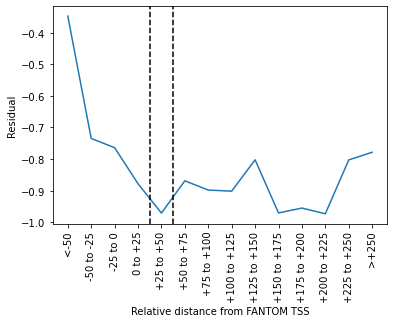

In [112]:
ax = sns.lineplot(data=tss_graph, x='tss_bins', y="Residual")
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Relative distance from FANTOM TSS', ylabel='Residual')
ax.axvline(3.5, 0,1, color = 'black', linestyle = '--')
ax.axvline(4.5, 0,1, color = 'black', linestyle = '--')
gpp.savefig('../figure/lfc_vs_tss_horlbeck_2016_tss_residual.pdf', dpi=300)



In [82]:
print(f"Training Accuracy: {model.score(X, y):0.2f}")
print(f"Test Accuracy: {model.score(horlbeck_2016_sept_X, horlbeck_2016_sept_y):0.2f}")

Training Accuracy: 0.02
Test Accuracy: -1.53


# Compare RS3 Chen seq score and RS3 Hsu seq score with the observed activity 

In [83]:
horlbeck_2016_sept_X['Crispri Target Score'] = model.predict(horlbeck_2016_sept_X)
horlbeck_2016_sept_X.reset_index(inplace=True)
X_val_pre_y = pd.merge(horlbeck_2016_sept, horlbeck_2016_sept_X, on = 'sgRNA Context Sequence')
X_val_pre_y['Crispri Sequence + Target Score'] = X_val_pre_y['Chen On-Target Efficacy Score'] + X_val_pre_y['Crispri Target Score']

In [84]:
X_val_pre_y['Crispri Sequence + Target Score'] = X_val_pre_y['Chen On-Target Efficacy Score'] + X_val_pre_y['Crispri Target Score']

In [85]:
gene_basis = X_val_pre_y.groupby('Target Gene Symbol')[['Residual','avg_mean_centered_neg_lfc','avg_lfc', 'Chen On-Target Efficacy Score', 'Crispri Target Score', 'Crispri Sequence + Target Score']].agg('mean')

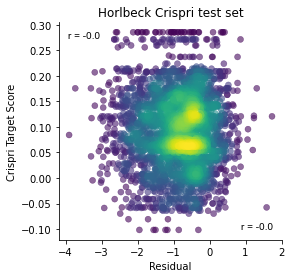

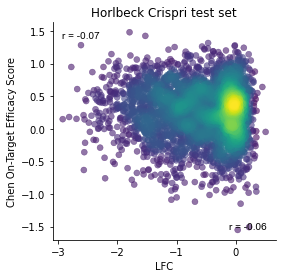

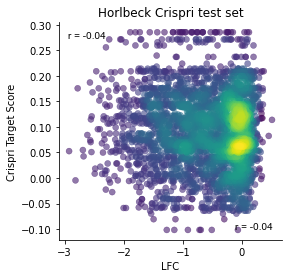

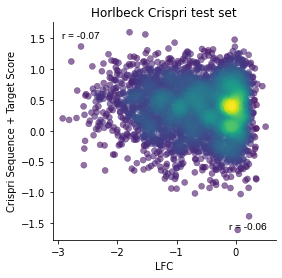

In [86]:
import gpplot as gpp
for x_axis in ['Residual','avg_lfc']:
    if x_axis == 'Residual':
        scores = ['Crispri Target Score']
        x_axis_name = 'Residual'
    else:
        scores = ['Chen On-Target Efficacy Score','Crispri Target Score', 'Crispri Sequence + Target Score']
        x_axis_name = 'LFC'
    for score in scores:
        plt.subplots(figsize=(4,4))
        gpplot.point_densityplot(data=X_val_pre_y[[score, x_axis]].dropna(),
                                 y=score, x=x_axis)
        gpplot.add_correlation(data=X_val_pre_y[[score, x_axis]].dropna(),
                               y=score, x=x_axis)
        gpplot.add_correlation(data=X_val_pre_y[[score, x_axis]].dropna(),
                                y=score, x=x_axis, method='spearman', loc='lower right')
        plt.xlabel(x_axis_name)
        plt.title("Horlbeck Crispri test set")
    #    plt.title(score)
        sns.despine()
        gpp.savefig('../figure/residual/Horlbeck'+score+'_vs_'+x_axis+'.pdf', dpi=300)
        


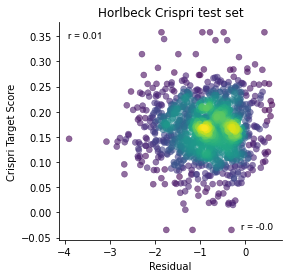

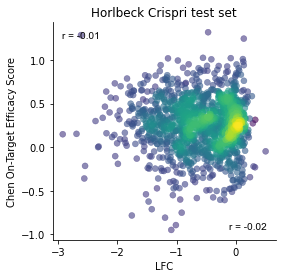

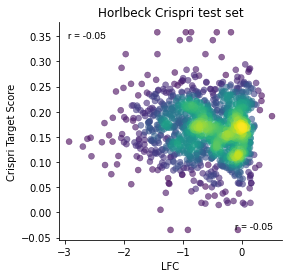

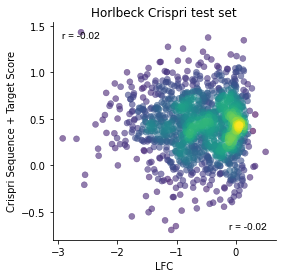

In [62]:

for x_axis in ['Residual','avg_lfc']:
    if x_axis == 'Residual':
        scores = ['Crispri Target Score']
        x_axis_name = 'Residual'
    else:
        scores = ['Chen On-Target Efficacy Score','Crispri Target Score', 'Crispri Sequence + Target Score']
        x_axis_name = 'LFC'
    for score in scores:
        plt.subplots(figsize=(4,4))
        gpplot.point_densityplot(data=gene_basis[[score, x_axis]].dropna(),
                                 y=score, x=x_axis)
        gpplot.add_correlation(data=gene_basis[[score, x_axis]].dropna(),
                               y=score, x=x_axis)
        gpplot.add_correlation(data=gene_basis[[score, x_axis]].dropna(),
                                y=score, x=x_axis, method='spearman', loc='lower right')
        plt.xlabel(x_axis_name)
        plt.title("Horlbeck Crispri test set")
    #    plt.title(score)
        sns.despine()
        


In [21]:
explainer = shap.TreeExplainer(model)


In [22]:
shap_values = explainer.shap_values(X)

In [23]:
from lightgbm import LGBMRegressor, plot_importance


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

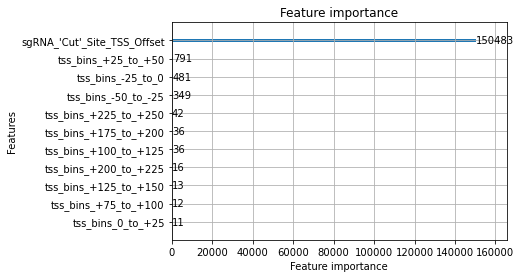

In [24]:
plot_importance(model)


In [87]:

explainer_model = shap.Explainer(model)
shap_values_model = explainer(X)
shap.plots.beeswarm(shap_values_model)

NameError: name 'explainer' is not defined

In [ ]:
#only bins 